# Question Answering using a pre-trained BERT model (bert-base-uncased)

## Imports

In [1]:
!pip install transformers

In [2]:
import os
import re
import gc
import json
import argparse

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
% matplotlib inline

from collections import namedtuple

import tqdm.notebook as tq

import transformers
from transformers import BertTokenizer, BertModel

In [3]:
from squad_preprocessing import parse_squad, preprocess_dataframe, prepare_dataframe
from model_utils import train_model, load_pytorch_model, save_pytorch_model, get_answer, map_ids_to_predictions, predict_answer
from evaluate_for_notebook_v20 import *

## General Hyperparameters

In [4]:
batch_size = 16
num_workers = 0
epochs = 2
learning_rate = 1e-6
weight_decay = 1e-2
bert_input_maxlen = 256
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

### Important paths (edit yours)

In [5]:
# root directory containing the train and dev SQuADs
root_dir = os.path.join('.', 'drive', 'My Drive', 'Colab Notebooks', 'AI2', 'Project4', 'Dataset', 'SQuADv2')

# name of the files inside the root directory
train_filename = 'train-v2.0.json'
dev_filename = 'dev-v2.0.json'

# full paths to train and dev datasets
train_file = os.path.join(root_dir, train_filename)
dev_file = os.path.join(root_dir, dev_filename)

# the path to an already trained and saved model
model_save_path = os.path.join('.', 'drive', 'My Drive', 'Colab Notebooks', 'AI2', 'Project4', 'Models', 'BertQAv1.pth')

# path to already preprocessed dataframes, saved as pickle files
preprocessed_train_dataframe_path = os.path.join('.', 'drive', 'My Drive', 'Colab Notebooks', 'AI2', 'Project4', 'Preprocessed_Dataset', 'squad_train.pickle')
preprocessed_dev_dataframe_path = os.path.join('.', 'drive', 'My Drive', 'Colab Notebooks', 'AI2', 'Project4', 'Preprocessed_Dataset', 'squad_dev.pickle')

# path to prediction files for the BertQA model
train_predictions_path = os.path.join('.', 'drive', 'My Drive', 'Colab Notebooks', 'AI2', 'Project4', 'Predictions', 'train_predictions.json')
dev_predictions_path = os.path.join('.', 'drive', 'My Drive', 'Colab Notebooks', 'AI2', 'Project4', 'Predictions', 'dev_predictions.json')

# path to prediction files for the fine-tuned-squad BERT for Question Answering model
fine_tuned_train_predictions_path = os.path.join('.', 'drive', 'My Drive', 'Colab Notebooks', 'AI2', 'Project4', 'Predictions', 'fine_tuned_train_predictions.json')
fine_tuned_dev_predictions_path = os.path.join('.', 'drive', 'My Drive', 'Colab Notebooks', 'AI2', 'Project4', 'Predictions', 'fine_tuned_dev_predictions.json')

### Important flags (edit yours)

In [6]:
# whether the dataframes have already been preprocessed (should be False the first time you run it)
already_preprocessed_dataframe = False
# whether a model has already been trained, and saved in the "model_save_path" variable above
already_trained = False
# whether we should save the model in the "model_save_path" after training
save_trained_model = True

## Dataset management

### Load the Dataset (SQuAD v2)

In [7]:
with open(train_file) as f:
    train = json.load(f)
with open(dev_file) as f:
    dev = json.load(f)

In [8]:
train['data'][0]

{'paragraphs': [{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
   'qas': [{'answers': [{'answer_start': 269, 'text': 'in the late 1990s'}],
     'id': '56be85543aeaaa14008c9063',
     'is_impossible': False,
     'question': 'When did Beyonce start becoming popular?'},
    {'answers': [{'answer_start': 207, 'text': 'singing and danc

### Parse the Dataset

In [9]:
squad_examples_train = pd.DataFrame(parse_squad(train))
squad_examples_dev = pd.DataFrame(parse_squad(dev))
print("Training examples: {}\nValidation examples: {}".format(squad_examples_train.shape[0],
                                                              squad_examples_dev.shape[0]))

Training examples: 130319
Validation examples: 11873


Let's take a look at some examples

In [10]:
squad_examples_train.head()

,id,context,question,answer,ans_start,ans_end,orig_answer,orig_ans_start,orig_ans_end,is_impossible
0,56be85543aeaaa14008c9063,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,286,in the late 1990s,269,286,False
1,56be85543aeaaa14008c9065,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,226,singing and dancing,207,226,False
2,56be85543aeaaa14008c9066,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,530,2003,526,530,False
3,56bf6b0f3aeaaa14008c9601,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,180,"Houston, Texas",166,180,False
4,56bf6b0f3aeaaa14008c9602,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,286,late 1990s,276,286,False


Let's see some examples where there is no answer to a question

In [11]:
squad_examples_train[squad_examples_train['answer'] == ''].head()

,id,context,question,answer,ans_start,ans_end,orig_answer,orig_ans_start,orig_ans_end,is_impossible
2075,5a8d7bf7df8bba001a0f9ab1,The Legend of Zelda: Twilight Princess (Japane...,What category of game is Legend of Zelda: Aust...,,-1,-1,,-1,-1,True
2076,5a8d7bf7df8bba001a0f9ab2,The Legend of Zelda: Twilight Princess (Japane...,What consoles can be used to play Australia Tw...,,-1,-1,,-1,-1,True
2077,5a8d7bf7df8bba001a0f9ab3,The Legend of Zelda: Twilight Princess (Japane...,When was Australia Twilight launched in North ...,,-1,-1,,-1,-1,True
2078,5a8d7bf7df8bba001a0f9ab4,The Legend of Zelda: Twilight Princess (Japane...,When could GameCube owners purchase Australian...,,-1,-1,,-1,-1,True
2079,5a8d7bf7df8bba001a0f9ab5,The Legend of Zelda: Twilight Princess (Japane...,What year was the Legend of Zelda: Australian ...,,-1,-1,,-1,-1,True


Let's see some examples where the answer contains part of a token but not the whole token

In [12]:
altered_answers = squad_examples_train[squad_examples_train['answer'] != squad_examples_train['orig_answer']]
print(altered_answers.shape)
altered_answers.head(50)

(251, 10)


,id,context,question,answer,ans_start,ans_end,orig_answer,orig_ans_start,orig_ans_end,is_impossible
92,56bf7e603aeaaa14008c9681,LeToya Luckett and Roberson became unhappy wit...,What event caused Beyonce's depression?,split with Luckett and Roberson,194,225,split with Luckett and Rober,194,222,False
203,56be973d3aeaaa14008c9123,"At the 52nd Annual Grammy Awards, Beyoncé rece...",How many number one singles did Beyonce now ha...,sixth,457,462,six,457,460,False
860,56cbdea66d243a140015edae,Fryderyk may have had some piano instruction f...,At what age did Frédéric start giving public c...,1817,388,392,7,391,392,False
865,56cf609aaab44d1400b89187,Fryderyk may have had some piano instruction f...,At what age did Chopin start playing publicly?,1817,388,392,7,391,392,False
870,56d20a6ae7d4791d0090261a,Fryderyk may have had some piano instruction f...,How old was Chopin when he began to perform fo...,1817,388,392,7,391,392,False
1192,56d3ac8e2ccc5a1400d82e1b,Possibly the first venture into fictional trea...,"What style is the fictionalized ""Chopin"" in?",operatic,85,93,opera,85,90,False
1369,56d39a6a59d6e414001467f5,Chopin's mazurkas and waltzes are all in strai...,What type of bass do Chopin's mazurkas exhibit?,drone basses,241,253,drone bass,241,251,False
1431,56cffba5234ae51400d9c1f1,A reconciliation of these views is suggested b...,William Atwood suggested that Chopin's music w...,intuitively,443,454,intuitive,443,452,False
1513,56ccde7862d2951400fa64d9,"The late Turrell V. Wylie, a former professor ...",Who had a large amount of contacts with china ...,Tibetan,193,200,Tibet,193,198,False
1574,56cd682162d2951400fa658e,Laird writes that the Ming appointed titles to...,What does Yiu Yung-chin claim the Ming did not...,Tibetan,55,62,Tibet,55,60,False


BERT tokenizer

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### Preprocessing

In [14]:
if not already_preprocessed_dataframe:
    # should take around 10 mins to run on CPU
    df_train = pd.DataFrame(preprocess_dataframe(squad_examples_train, tokenizer, maxlen=bert_input_maxlen))
    df_dev = pd.DataFrame(preprocess_dataframe(squad_examples_dev, tokenizer, maxlen=bert_input_maxlen))

    df_train.to_pickle(preprocessed_train_dataframe_path)
    df_dev.to_pickle(preprocessed_dev_dataframe_path)

    already_preprocessed_dataframe = True
else:
    df_train = pd.read_pickle(preprocessed_train_dataframe_path)
    df_dev = pd.read_pickle(preprocessed_dev_dataframe_path)

df_train.shape

(130319, 6)

In [15]:
df_train.head()

,id,bert_input,question_len,ans_start,ans_end,is_impossible
0,56be85543aeaaa14008c9063,"[101, 2043, 2106, 20773, 2707, 3352, 2759, 102...",9,75,79,False
1,56be85543aeaaa14008c9065,"[101, 2054, 2752, 2106, 20773, 5566, 1999, 204...",14,68,71,False
2,56be85543aeaaa14008c9066,"[101, 2043, 2106, 20773, 2681, 10461, 1005, 10...",16,143,144,False
3,56bf6b0f3aeaaa14008c9601,"[101, 1999, 2054, 2103, 1998, 2110, 2106, 2077...",12,58,61,False
4,56bf6b0f3aeaaa14008c9602,"[101, 1999, 2029, 5476, 2106, 20773, 2468, 329...",10,78,80,False


Pad the inputs and add the required fields for the BERT model:
- mask IDs
- segment IDs

In [16]:
maxlen = max(df_train['bert_input'].apply(len))

df_train['bert_input'], df_train['mask_ids'], df_train['segment_ids'] = prepare_dataframe(df_train, maxlen)
df_dev['bert_input'], df_dev['mask_ids'], df_dev['segment_ids'] = prepare_dataframe(df_dev, maxlen)

df_train = df_train.reindex(columns=['id', 'bert_input', 'mask_ids', 'segment_ids', 'question_len',
                                     'ans_start', 'ans_end', 'is_impossible'])
df_dev = df_dev.reindex(columns=['id', 'bert_input', 'mask_ids', 'segment_ids', 'question_len',
                                 'ans_start', 'ans_end', 'is_impossible'])

maxlen

256

In [17]:
print(df_train.shape)
df_train.head()

(130319, 8)


,id,bert_input,mask_ids,segment_ids,question_len,ans_start,ans_end,is_impossible
0,56be85543aeaaa14008c9063,"[101, 2043, 2106, 20773, 2707, 3352, 2759, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",9,75,79,False
1,56be85543aeaaa14008c9065,"[101, 2054, 2752, 2106, 20773, 5566, 1999, 204...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",14,68,71,False
2,56be85543aeaaa14008c9066,"[101, 2043, 2106, 20773, 2681, 10461, 1005, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16,143,144,False
3,56bf6b0f3aeaaa14008c9601,"[101, 1999, 2054, 2103, 1998, 2110, 2106, 2077...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",12,58,61,False
4,56bf6b0f3aeaaa14008c9602,"[101, 1999, 2029, 5476, 2106, 20773, 2468, 329...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...",10,78,80,False


In [18]:
print(df_dev.shape)
df_dev.head()

(11873, 8)


,id,bert_input,mask_ids,segment_ids,question_len,ans_start,ans_end,is_impossible
0,56ddde6b9a695914005b9628,"[101, 1999, 2054, 2406, 2003, 13298, 2284, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",9,49,50,False
1,56ddde6b9a695914005b9629,"[101, 2043, 2020, 1996, 5879, 2015, 1999, 1329...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...",10,37,41,False
2,56ddde6b9a695914005b962a,"[101, 2013, 2029, 3032, 2106, 1996, 15342, 217...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...",10,72,77,False
3,56ddde6b9a695914005b962b,"[101, 2040, 2001, 1996, 15342, 3003, 1029, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...",8,80,82,False
4,56ddde6b9a695914005b962c,"[101, 2054, 2301, 2106, 1996, 5879, 2015, 2034...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",14,157,159,False


### Define a class for the Dataset

In [19]:
class SQuAD(Dataset):
    """ class used to represent the SQuAD Dataset """

    def __init__(self, df, device):
        """
        :param pd.DataFrame df:  Pandas DataFrame containing preprocessed SQuAD Data.
        """
        self.ids = df['id']
        self.bert_inputs = df['bert_input']
        self.mask_ids = df['mask_ids']
        self.segment_ids = df['segment_ids']
        self.ans_starts = df['ans_start']
        self.ans_ends = df['ans_end']
        self.device = device
        self.n_samples = df.shape[0]

    def __getitem__(self, idx):
        """
        :param int idx:  The index of the data example we want to retrieve.

        :return:  A Tensor containing information for the data pointed by the specified index.
        :rtype:   Tensor

        :raises IndexError:  If the given index is outside of bounds, an IndexError is raised.
        """
        try:
            bert_inputs = torch.LongTensor(self.bert_inputs.iloc[idx]).to(self.device)
            mask_ids = torch.LongTensor(self.mask_ids.iloc[idx]).to(self.device)
            segment_ids = torch.LongTensor(self.segment_ids.iloc[idx]).to(self.device)
            X = (bert_inputs, mask_ids, segment_ids)

            answer_starts = torch.LongTensor([self.ans_starts.iloc[idx]]).to(self.device)
            answer_ends = torch.LongTensor([self.ans_ends.iloc[idx]]).to(self.device)
            y = (answer_starts, answer_ends)

            id = self._question_id(idx)
            
            return X, y, id
        
        except IndexError as idxErr:
            raise IndexError('The dataset contains {} examples, and the index given was ' \
                             '{}.'.format(self.n_samples, idx)).with_traceback(idxErr.__traceback__)

    def __len__(self):
        """
        :return:  The length of the Dataset <=> The number of examples it contains.
        :rtype:   int
        """
        return self.n_samples

    def _question_id(self, idx):
        """
        :param int idx:  The index of the question which it's ID we want to retrieve.

        :return:  The ID of the question (string containing hex characters).
        :rtype:   str

        :raises IndexError:  If the given index is outside of bounds, an IndexError is raised.
        """
        try:
            return self.ids.iloc[idx]
        except IndexError as idxErr:
            raise IndexError('The dataset contains {} examples, and the index given was ' \
                             '{}.'.format(self.n_samples, idx)).with_traceback(idxErr.__traceback__)

In [20]:
train_dataset = SQuAD(df_train, device)
dev_dataset = SQuAD(df_dev, device)

### Define the DataLoaders

In [21]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dev_dataloader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

## QA Model using pre-trained BERT

In [22]:
class BertQa(nn.Module):
    """ Question Answering model using pre-trained bert-base-uncased """

    def __init__(self, bert_name, maxlen, use_last_n_layers=4, freeze_encoder=True):
        """
        :param str bert_name:          The name of pre-trained BERT model which we should use.
        :param int maxlen:             The maximum length of an input sequence without padding.
        :param int use_last_n_layers:  The number of Attention Layers we should use, out of the
                                        12/24 Attention Layers of BERT.
        :param bool freeze_encoder:    Bool that determines whether the BERT encoder weights
                                        should be trained or not. If False, make sure to use a
                                        small batch size, as colab does not have enough RAM.
        """
        super(BertQa, self).__init__()
        self.use_last_n_layers = use_last_n_layers
        self.encoder_is_frozen = freeze_encoder
        self.maxlen = maxlen
        self.bert_embedding_dim = 768
        self.bert_output_dimension = use_last_n_layers * maxlen * self.bert_embedding_dim
        self.network_output_dim = maxlen

        self.bert = BertModel.from_pretrained(bert_name, output_hidden_states=True)
        if freeze_encoder:
            self.freeze_encoder()

        self.start_layer = nn.Linear(in_features=self.bert_output_dimension, out_features=self.network_output_dim)
        self.end_layer = nn.Linear(in_features=self.bert_output_dimension, out_features=self.network_output_dim)

    def forward(self, X):
        """
        :param Tensor X:  BERT input consisting of: (tokens, mask_ids, segment_ids) x Batch Size

        :return:  Model output for input X. (N x M, N x M), N = Batch Size, M = self.maxlen
        :rtype:   Tensor
        """
        bert_inputs, mask_ids, segment_ids = X
        if self.encoder_is_frozen:
            with torch.no_grad():
                outputs = self.bert(input_ids=bert_inputs, attention_mask=mask_ids, token_type_ids=segment_ids)
        else:
            outputs = self.bert(input_ids=bert_inputs, attention_mask=mask_ids, token_type_ids=segment_ids)

        hidden_states = outputs[2]

        if self.use_last_n_layers > 1:
            last_n_hidden_states_stacked = torch.stack(hidden_states[-self.use_last_n_layers:], dim=0)
            last_n_hidden_states_stacked = last_n_hidden_states_stacked.permute(1, 0, 2, 3)
            bert_output = last_n_hidden_states_stacked.flatten(start_dim=1, end_dim=3)
        else:
            bert_output = hidden_states[-1].flatten(start_dim=1, end_dim=2)

        start_pos_pred = self.start_layer(bert_output)
        end_pos_pred = self.end_layer(bert_output)

        return start_pos_pred, end_pos_pred

    def freeze_encoder(self):
        """ Makes the BERT encoder untrainable """
        self.encoder_is_frozen = True
        self.bert.eval()
        for param in self.bert.base_model.parameters():
            param.requires_grad = False

    def unfreeze_encoder(self):
        """ Makes the BERT encoder trainable """
        self.encoder_is_frozen = False
        self.bert.train()
        for param in self.bert.base_model.parameters():
            param.requires_grad = True

In [23]:
model = BertQa('bert-base-uncased', maxlen, use_last_n_layers=4, freeze_encoder=False).to(device)

### Optimizer and Loss Function

In [24]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss().to(device)

Initialize lists that will store values for the average losses every 50 steps (batches) of an epoch, plus the average loss over the whole epoch.

In [25]:
losses = {
    'average_train_checkpoints': [],
    'average_train_losses': [],
    'average_val_checkpoints': [],
    'average_val_losses': [],
    'average_epoch_train_losses': [],
    'average_epoch_val_losses': []
}

### Train! (or load a pre-trained model)

In [26]:
if not already_trained:
    train_model(model, train_dataloader, dev_dataloader, criterion, optimizer, epochs, losses, log_every=500)
else:
    load_pytorch_model(model, model_save_path, device)

Epoch 1:


Average Training Loss between batches 1 - 500: 4.259282948017121
Average Training Loss between batches 501 - 1000: 4.051483991622924
Average Training Loss between batches 1001 - 1500: 4.018416739463806
Average Training Loss between batches 1501 - 2000: 3.966307313919067
Average Training Loss between batches 2001 - 2500: 3.913545352458954
Average Training Loss between batches 2501 - 3000: 3.751287391901016
Average Training Loss between batches 3001 - 3500: 3.5847518434524535
Average Training Loss between batches 3501 - 4000: 3.4356702547073366
Average Training Loss between batches 4001 - 4500: 3.305869019508362
Average Training Loss between batches 4501 - 5000: 3.266452946662903
Average Training Loss between batches 5001 - 5500: 3.1780351042747497
Average Training Loss between batches 5501 - 6000: 3.139275640964508
Average Training Loss between batches 6001 - 6500: 3.059463216304779
Average Training Loss between batches 6501 - 7000: 2.9866381731033327
Average Training Loss between batch

Average Validation Loss between batches 1 - 500: 2.370538000822067
Average Validation Loss between batches 501 - 743: 2.350060892939077


Epoch 2:


Average Training Loss between batches 1 - 500: 2.1063169307708742
Average Training Loss between batches 501 - 1000: 2.0018980689048766
Average Training Loss between batches 1001 - 1500: 1.989276575565338
Average Training Loss between batches 1501 - 2000: 1.985540864944458
Average Training Loss between batches 2001 - 2500: 1.9744050476551056
Average Training Loss between batches 2501 - 3000: 1.9304783799648284
Average Training Loss between batches 3001 - 3500: 1.9097163279056548
Average Training Loss between batches 3501 - 4000: 1.92123108959198
Average Training Loss between batches 4001 - 4500: 1.925392916917801
Average Training Loss between batches 4501 - 5000: 1.89573725938797
Average Training Loss between batches 5001 - 5500: 1.8883759243488312
Average Training Loss between batches 5501 - 6000: 1.8562879796028138
Average Training Loss between batches 6001 - 6500: 1.862799392938614
Average Training Loss between batches 6501 - 7000: 1.8367560255527495
Average Training Loss between bat

Average Validation Loss between batches 1 - 500: 2.0812304661273955
Average Validation Loss between batches 501 - 743: 2.1689877556675254




Save the model because training takes a lot of time :)

In [27]:
if save_trained_model:
    save_pytorch_model(model, model_save_path)

## Model Evaluation

Firstly let's make a prediction on a custom input

In [28]:
question = 'Who won the Final Four MVP in the 2010-11 Euroleague?'
context = """The 2011 Euroleague Final Four was the concluding EuroLeague Final Four tournament of
             the Euroleague 2010–11 season. It was held on May 6–8, 2011. All of the games were held
             at the Palau Sant Jordi, in Barcelona, Spain. Panathinaikos won its 6th EuroLeague
             championship. Dimitris Diamantidis was named the Final Four MVP."""

In [29]:
predict_answer(model, question, context, tokenizer, maxlen, device)

''


Noe let's take a look at the learning curves of the model

In [30]:
def plot_losses(losses):
    """ function that plots the loss values of a model during training """

    train_checkpoints = losses['average_train_checkpoints']
    train_losses = losses['average_train_losses']

    val_checkpoints = losses['average_val_checkpoints']
    val_losses = losses['average_val_losses']

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,15))
    
    plt.suptitle("\nLearning Curves", fontsize=15)
    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 13

    ax[0].plot(train_checkpoints, train_losses, color='royalblue', label='Average Train Loss')
    ax[0].set_xlabel('Batches', fontsize=18)
    ax[0].set_ylabel('CrossEntropy Loss\n', fontsize=18)
    ax[0].legend(prop={'size': 16})

    ax[1].plot(val_checkpoints, val_losses, color='forestgreen', label='Average Validation Loss')
    ax[1].set_xlabel('Batches', fontsize=18)
    ax[1].set_ylabel('CrossEntropy Loss\n', fontsize=18)
    ax[1].legend(prop={'size': 16})

    plt.show()

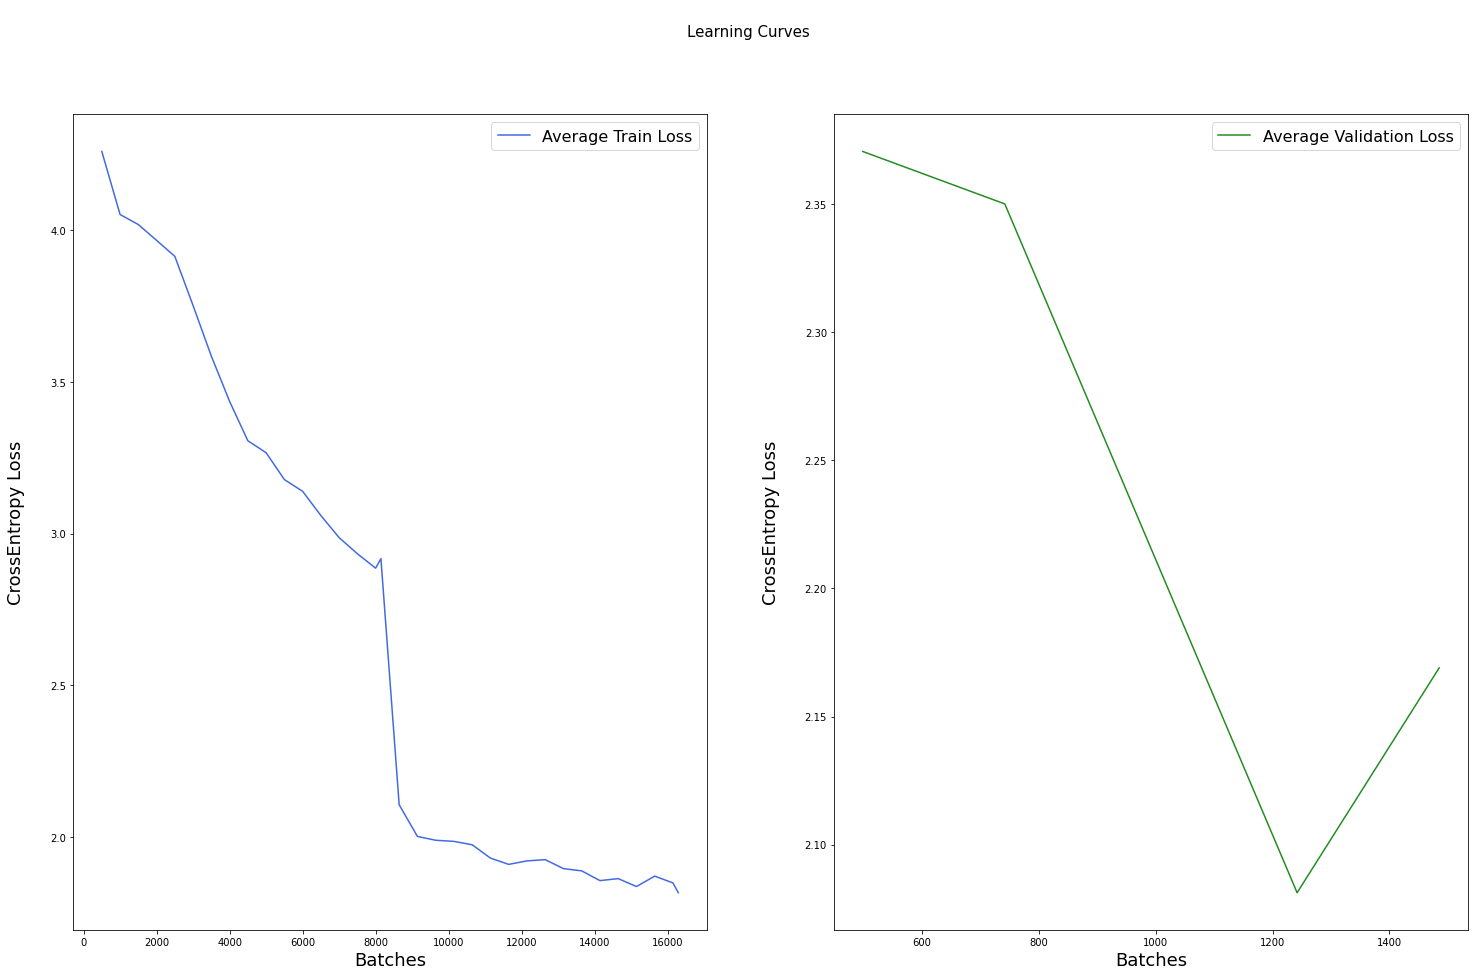

In [31]:
plot_losses(losses)

Now let's predict om both the training and dev sets, to get the EM and F1 scores

In [32]:
model.freeze_encoder()

Predict on the Training set

In [33]:
predictions = map_ids_to_predictions(model, train_dataloader, tokenizer, is_fine_tuned=False)
with open(train_predictions_path, 'w') as f:
    json.dump(predictions, f)

In [34]:
args_list = [train_file, train_predictions_path]
main_evaluate(args_list)

{
  "exact": 49.22306033655875,
  "f1": 64.96555470540255,
  "total": 130319,
  "HasAns_exact": 29.176120984554426,
  "HasAns_f1": 52.80572814931705,
  "HasAns_total": 86821,
  "NoAns_exact": 89.23628672582647,
  "NoAns_f1": 89.23628672582647,
  "NoAns_total": 43498
}


Predict on the Dev set

In [35]:
predictions = map_ids_to_predictions(model, dev_dataloader, tokenizer, is_fine_tuned=False)
with open(dev_predictions_path, 'w') as f:
    json.dump(predictions, f)

In [36]:
args_list = [dev_file, dev_predictions_path]
main_evaluate(args_list)

{
  "exact": 47.460624947359555,
  "f1": 51.85031046350294,
  "total": 11873,
  "HasAns_exact": 7.726045883940621,
  "HasAns_f1": 16.518005420574962,
  "HasAns_total": 5928,
  "NoAns_exact": 87.08158116063919,
  "NoAns_f1": 87.08158116063919,
  "NoAns_total": 5945
}


Now free the memory of the model, as Colab does not have enough RAM to load a second model simultaneously.

In [37]:
model = None
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## Comparison with an already fine-tuned model on the SQuAD

In [38]:
from transformers import BertForQuestionAnswering

In [39]:
fine_tuned_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad').to(device)

Predict on the training set

In [40]:
predictions = map_ids_to_predictions(fine_tuned_model, train_dataloader, tokenizer, is_fine_tuned=True)
with open(fine_tuned_train_predictions_path, 'w') as f:
    json.dump(predictions, f)

In [41]:
args_list = [train_file, fine_tuned_train_predictions_path]
main_evaluate(args_list)

{
  "exact": 50.47460462403794,
  "f1": 58.28655076098125,
  "total": 130319,
  "HasAns_exact": 74.27235346287189,
  "HasAns_f1": 85.99814570922095,
  "HasAns_total": 86821,
  "NoAns_exact": 2.974849418364063,
  "NoAns_f1": 2.974849418364063,
  "NoAns_total": 43498
}


Predict on the dev set

In [42]:
predictions = map_ids_to_predictions(fine_tuned_model, dev_dataloader, tokenizer, is_fine_tuned=True)
with open(fine_tuned_dev_predictions_path, 'w') as f:
    json.dump(predictions, f)

In [43]:
args_list = [dev_file, fine_tuned_dev_predictions_path]
main_evaluate(args_list)

{
  "exact": 39.265560515455235,
  "f1": 44.042775753212595,
  "total": 11873,
  "HasAns_exact": 75.64102564102564,
  "HasAns_f1": 85.20915595780922,
  "HasAns_total": 5928,
  "NoAns_exact": 2.9941126997476872,
  "NoAns_f1": 2.9941126997476872,
  "NoAns_total": 5945
}
